In [23]:
import os.path
import cv2
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
import src.metrics as nc_metrics
import src.utils as nc_utils
import notebooks.sandbox.models as nc_models

from pathlib import Path
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import models

from tensorflow.keras.metrics import Recall, Precision

In [24]:
strategy = nc_utils.start_session()

ROOT_DIR = "."
IMAGE_DIR = os.path.join(ROOT_DIR, "images")
MASK_DIR = os.path.join(ROOT_DIR, "masks")

BATCH_SIZE = 4
LR = 1e-3  # Learning rate
EPOCHS = 300

smallest_dimension = nc_utils.get_smallest_image_dimension(IMAGE_DIR)

#IMAGE_SIZE = smallest_dimension
IMAGE_SIZE = 256
IMAGE_SHAPE = (IMAGE_SIZE, IMAGE_SIZE)
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

In [25]:
(x_train_paths, y_train_paths), (x_valid_paths, y_valid_paths), (
x_test_paths,
y_test_paths) = nc_utils.load_data(
    image_directory=IMAGE_DIR,
    mask_directory=MASK_DIR,
    split=0.1
)

train_dataset = nc_utils.get_tensorflow_dataset(
    image_mask_paths=(x_train_paths, y_train_paths),
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

validation_dataset = nc_utils.get_tensorflow_dataset(
    image_mask_paths=(x_valid_paths, y_valid_paths),
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

test_dataset = nc_utils.get_tensorflow_dataset(
    image_mask_paths=(x_test_paths, y_test_paths),
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

data_aug = nc_utils.get_data_augmentation_pipeline()

In [26]:
# Initiating model on GPU
with strategy.scope():
    model = nc_models.unet_model(input_shape=INPUT_SHAPE, augment_data=True)
    metrics=[nc_metrics.continuous_dice_coefficient, nc_metrics.dice_coefficient]
    loss=nc_metrics.cdc_loss
    opt=tf.keras.optimizers.Nadam(LR)

In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 sequential_1 (Sequential)   (None, 256, 256, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['sequential_1[0][0]']        
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['conv2d[0][0]']              
                                                                                              

In [28]:
# Compiling model
model.compile(optimizer=opt,
              loss=loss,
              metrics=metrics)

early_stopping = callbacks.EarlyStopping(monitor='val_loss',
                                         patience=10,
                                         restore_best_weights=True)
reduce_learning = callbacks.ReduceLROnPlateau(monitor='val_loss',
                                              factor=0.1,
                                              patience=4)

In [29]:
train_steps = len(x_train_paths) // BATCH_SIZE
valid_steps = len(x_valid_paths) // BATCH_SIZE

if len(x_train_paths) % BATCH_SIZE != 0:
    train_steps += 1
if len(x_valid_paths) % BATCH_SIZE != 0:
    valid_steps += 1

try:
    history = model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=validation_dataset,
        callbacks=[early_stopping, reduce_learning],
        steps_per_epoch=train_steps,
        validation_steps=valid_steps)
except Exception as e:
    print("An error occurred:", e)

Epoch 1/300


2024-02-15 23:30:52.367299: W external/local_tsl/tsl/framework/bfc_allocator.cc:366] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


66/66 [==============================] - 114s 1s/step - loss: 0.9854 - continuous_dice_coefficient: 0.0146 - dice_coefficient: 0.0145 - val_loss: 0.9993 - val_continuous_dice_coefficient: 0.0014 - val_dice_coefficient: 0.0014 - lr: 0.0010
Epoch 2/300
66/66 [==============================] - 61s 926ms/step - loss: 0.9992 - continuous_dice_coefficient: 8.2172e-04 - dice_coefficient: 8.2172e-04 - val_loss: 0.9993 - val_continuous_dice_coefficient: 0.0014 - val_dice_coefficient: 0.0014 - lr: 0.0010
Epoch 3/300
66/66 [==============================] - 61s 930ms/step - loss: 0.9992 - continuous_dice_coefficient: 8.2172e-04 - dice_coefficient: 8.2172e-04 - val_loss: 0.9993 - val_continuous_dice_coefficient: 0.0014 - val_dice_coefficient: 0.0014 - lr: 0.0010
Epoch 4/300
66/66 [==============================] - 52s 795ms/step - loss: 0.9992 - continuous_dice_coefficient: 8.2172e-04 - dice_coefficient: 8.2172e-04 - val_loss: 0.9993 - val_continuous_dice_coefficient: 0.0014 - val_dice_coefficient

In [30]:
test_steps = len(x_test_paths) // BATCH_SIZE
if len(x_test_paths) % BATCH_SIZE != 0:
    test_steps += 1
    
model.evaluate(test_dataset, steps=test_steps)

9/9 [==============================] - 2s 224ms/step - loss: 0.9693 - continuous_dice_coefficient: 0.1115 - dice_coefficient: 0.1115


[0.969326376914978, 0.11145087331533432, 0.11145087331533432]

# Results

In [31]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = np.expand_dims(x, axis=-1)
    x = x/255.0
    return x

In [32]:
def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

1/1 [==============================] - 0s 85ms/step


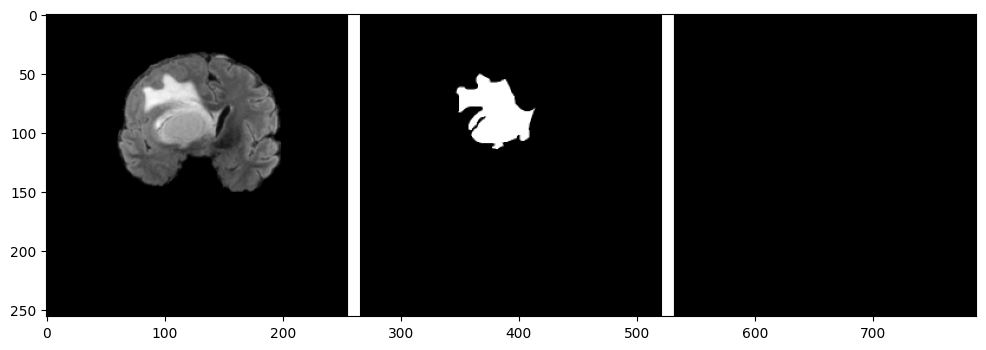

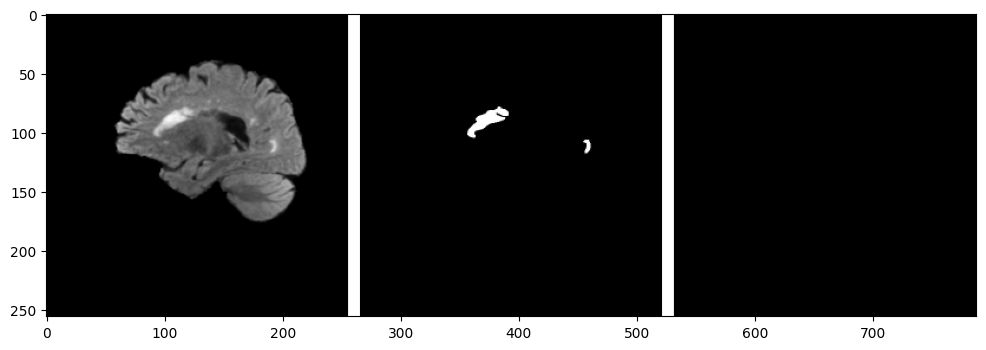

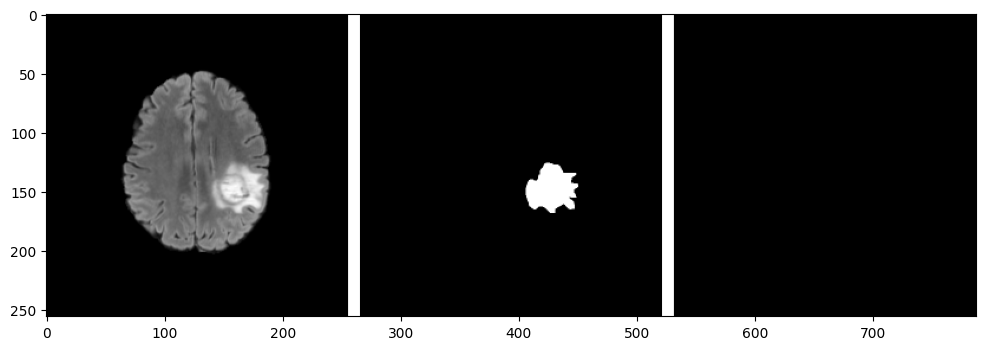

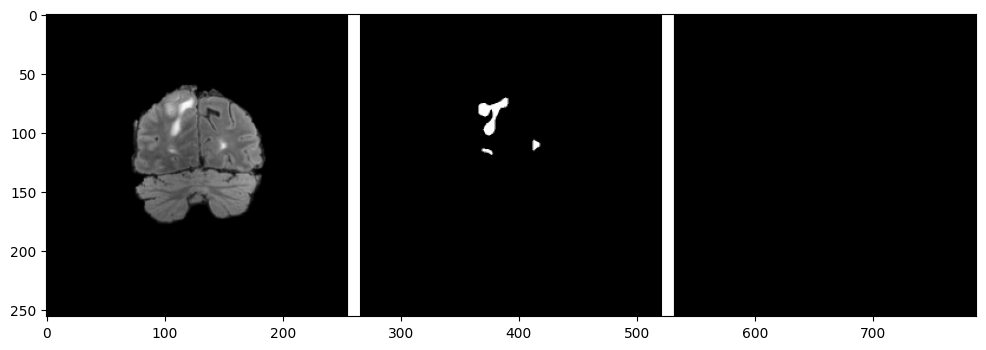

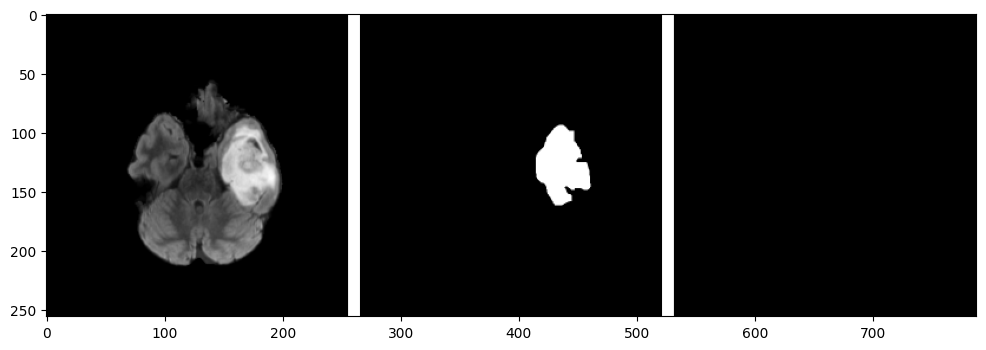

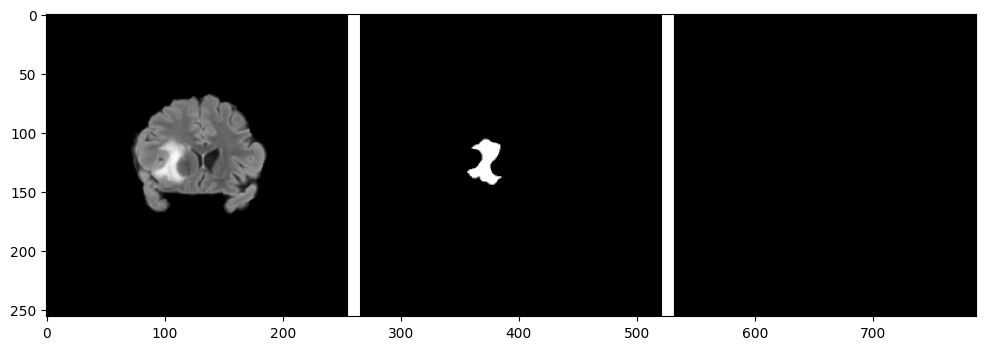

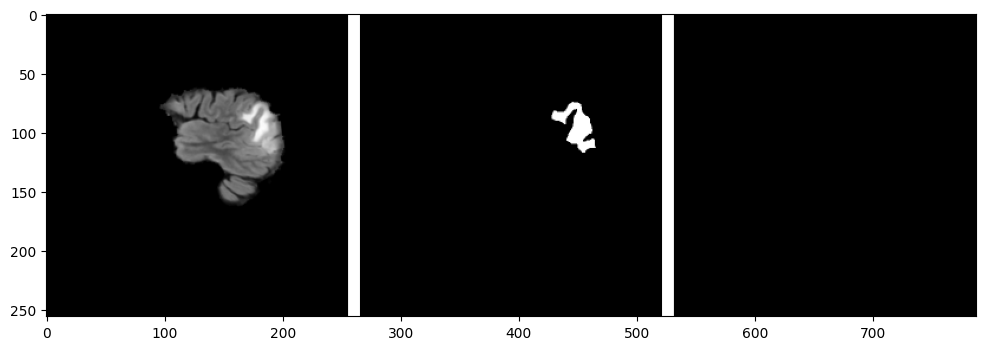

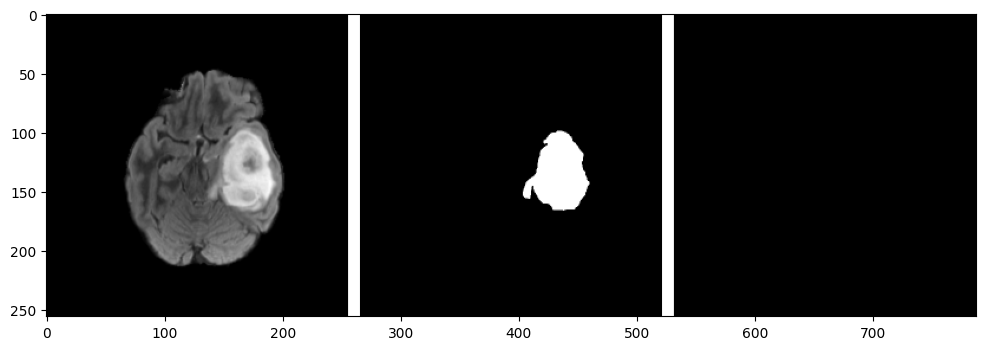

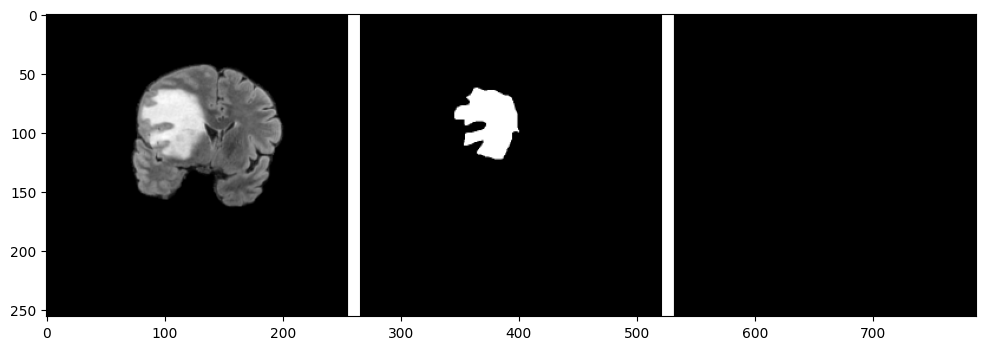

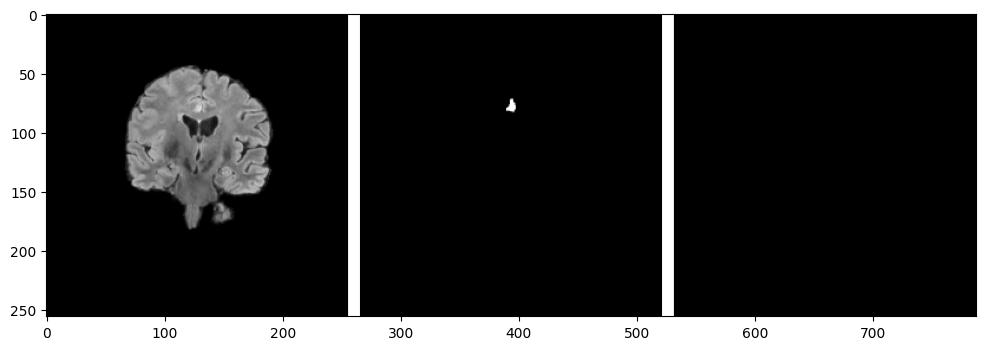

In [33]:
for i, (x, y) in enumerate(zip(x_test_paths[:10], y_test_paths[:10])):
    x = read_image(x)
    y = read_mask(y)
    y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
    h, w, _ = x.shape
    white_line = np.ones((h, 10, 3))

    all_images = [
        x, white_line,
        mask_parse(y), white_line,
        mask_parse(y_pred)
    ]
    image = np.concatenate(all_images, axis=1)

    fig = plt.figure(figsize=(12, 12))
    a = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)